In [ ]:
# import numerical functions, plotting functions and statistical functions
import numpy as np
# !pip install pip
# !pip install --upgrade pip
# !pip install scipy
import scipy as sp
import scipy.stats
import pandas as pd
import json
from sklearn.preprocessing import RobustScaler

# !pip install pystan
import stan
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# !pip install arviz
import arviz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [ ]:
# !pip uninstall numba
# !pip install --upgrade numba

In [87]:
def diagnose(name):
    if 'disease' in name:
        return 1
    else:
        return 0

def region_id(segment_region):
    if "glomerulus" in segment_region:
        return 1
    elif "tubule" in segment_region:
        return 2
    else:
        return -1
    # elif segment_region == "neg tubule":
    #     return 3
    # else:
    #     return -1

In [114]:
raw_df = pd.read_csv('./data/kidney_countdata.txt', sep='\t', quotechar='"')
raw_df.rename(columns={'Unnamed: 0': 'gene'}, inplace=True)

meta_df = pd.read_csv('./data/kidney_metadata.txt', sep='\t', quotechar='"')
meta_df.rename(columns={'Unnamed: 0': 'ROI'}, inplace=True)
meta_df['diagnosis'] = meta_df['slide name'].map(diagnose)
meta_df['segment_region'] = meta_df['segment'] + ' ' + meta_df['region']
meta_df['region_id'] = meta_df['segment_region'].map(region_id)
print(meta_df.groupby(['region_id', 'diagnosis']).count())


                     ROI  construct  read_pattern  expected_neg  slide name  \
region_id diagnosis                                                           
1         0           81         81            81            81          81   
          1          109        109           109           109         109   
2         0           36         36            36            36          36   
          1           50         50            50            50          50   

                     class  segment  area  region  pathology  nuclei  \
region_id diagnosis                                                    
1         0             81       81    81      81         68      81   
          1            109      109   109     109         83     109   
2         0             36       36    36      36          0      36   
          1             50       50    50      50          0      50   

                     segment_region  
region_id diagnosis                  
1         0     

### Data Summary


In [ ]:
print(f"Number of genes: {raw_df.shape[0]}")
print(f"Number of ROIs: {len(meta_df['ROI'].unique())}")
print("Diagnosis counts:")
print(meta_df['diagnosis'].value_counts())
print(f"ROIs per individual")
print(meta_df['slide name'].value_counts())

In [ ]:

sns.histplot([str(x) for x in meta_df['diagnosis'].values])
plt.title('Histogram of Diagnosis')
plt.show()

sns.histplot(meta_df['slide name'])
plt.title('Counts of ROIs from each individual')
plt.show()

In [ ]:
means = raw_df.mean(axis=0)
sns.histplot(means)
plt.title('Histogram of mean expression across ROIs')
plt.xlabel('Mean expression')
plt.show()

stds = raw_df.std(axis=0)
sns.histplot(stds)
plt.title('Histogram of standard deviation of expression across ROIs')
plt.xlabel('Standard deviation of expression')
plt.show()

In [89]:
def prepare_and_save_data(test_individuals=['disease2B', 'normal4'], normalization='z-score', region=False):
    # Option 0: Remove test subjects from the data
    if len(test_individuals) > 0:
        test_ROIs = meta_df[meta_df['slide name'].isin(test_individuals)]['ROI'].values
        suffix = '_indv'
    # Option 2: randomly sample 20 ROIs from each class to be the test set
    else:
        d_vals = meta_df[meta_df['diagnosis'] == 1]['ROI'].values
        d_vals = np.random.permutation(d_vals)
        d_vals = d_vals[:20]
        n_vals = meta_df[meta_df['diagnosis'] == 0]['ROI'].values
        n_vals = np.random.permutation(n_vals)
        n_vals = n_vals[:20]
        test_ROIs = np.concatenate((d_vals, n_vals))
        suffix = '_random_20'
    
    df = raw_df
    column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col not in test_ROIs]
    test_column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col in test_ROIs]

    # # Option 1: normalize by sum of all counts for an ROI, multiplied by 1,000 to prevent underflow
    if normalization == 'sum':
        X = [(df[col]*1000/sum(df[col])).tolist() for col in column_list]
        test_X = [(df[col]*1000/sum(df[col])).tolist() for col in test_column_list]
    # Option 2: normalize using z-score method:
    elif normalization == 'z-score':
        X = [sp.stats.zscore(df[col]).tolist() for col in column_list]
        test_X = [sp.stats.zscore(df[col]).tolist() for col in test_column_list]
    # # Option 3: normalize using min-max method:
    elif normalization == 'min-max':
        X = [((df[col]-min(df[col]))/(max(df[col])-min(df[col]))).tolist() for col in column_list]
        test_X = [((df[col]-min(df[col]))/(max(df[col])-min(df[col]))).tolist() for col in test_column_list]
    # # Option 4: normalize using quantile method:
    elif normalization == 'quantile':
        X = []
        test_X = []
        for col in column_list:
            rs = RobustScaler()
            scaled = rs.fit_transform(df[col].values.reshape(-1, 1))
            X.append(scaled.tolist())

        for col in test_column_list:
            rs = RobustScaler()
            scaled = rs.fit_transform(df[col].values.reshape(-1, 1))
            test_X.append(scaled.tolist())
    else:
        raise ValueError('Invalid normalization method')

    Y = []
    for col in column_list:
        Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))

    test_Y = []
    for col in test_column_list:
        test_Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))


    ROI_df = pd.DataFrame(column_list, columns=['ROI'])
    joined = ROI_df.merge(meta_df, on='ROI', how='left')
    p = len(joined['region_id'].unique())

    test_ROI_df = pd.DataFrame(test_column_list, columns=['ROI'])
    test_regions= test_ROI_df.merge(meta_df, on='ROI', how='left')['region_id'].values.tolist()

    if region:
        reg_suffix = '_reg'
        data = {'N': len(X), 'q': len(df), 'p': p, 'X': X, 'Y': Y, 'region': joined['region_id'].values.tolist()}
    else:
        reg_suffix = ''
        data = {'N': len(X), 'q': len(df), 'X': X, 'Y': Y}

    with open(f"/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/genes/model_norm/model{reg_suffix}{suffix}.data.json", "w") as f:
        json.dump(data, f)
    
    return data, test_X, test_Y, test_regions


In [90]:
region_setting = True
data_indv, test_X_indv, test_Y_indv, test_region_indv = prepare_and_save_data(test_individuals=['disease2B', 'normal2B'], normalization='z-score', region=region_setting)
data_rand, test_X_rand, test_Y_rand, test_region_rand = prepare_and_save_data(test_individuals=[], normalization='z-score', region=region_setting)

In [92]:
print(min(data_indv['region']))

1


204
204


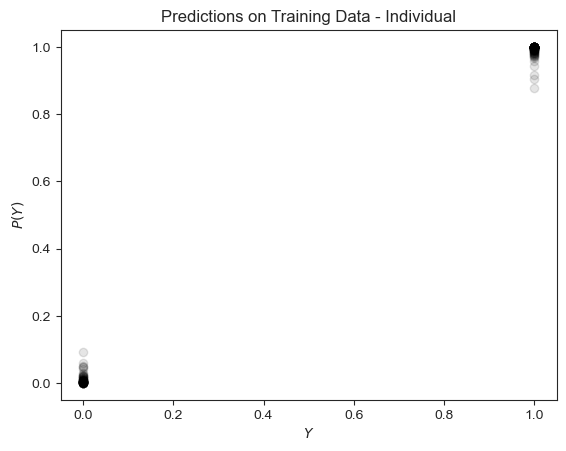

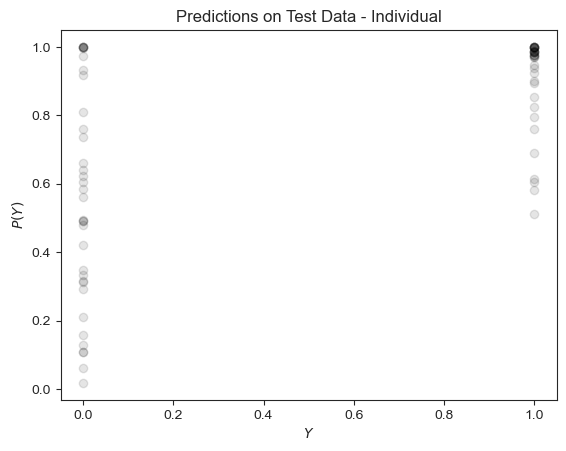

        P(Y)  accuracy  samples
Y                              
0  19.570540        17       35
1  33.570994        37       37
236
236


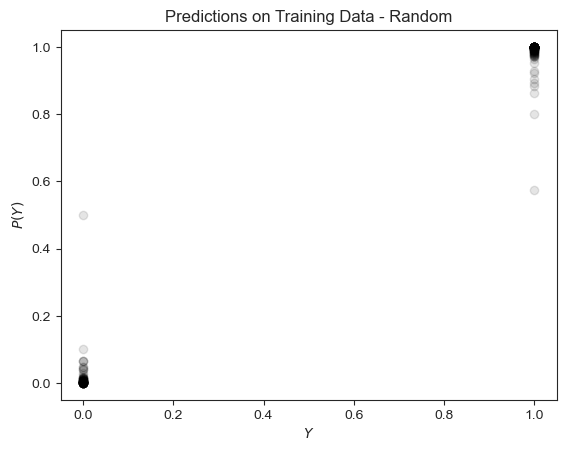

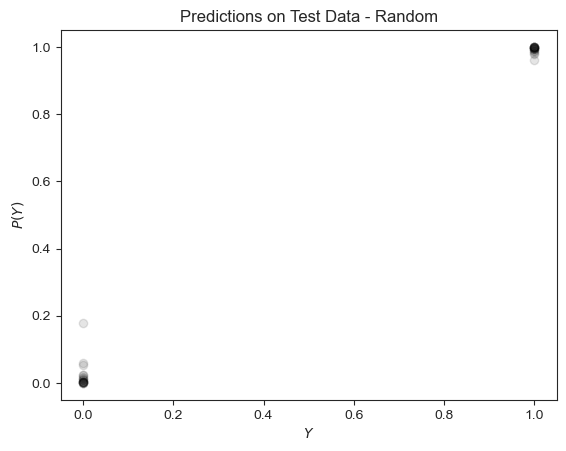

        P(Y)  accuracy  samples
Y                              
0   0.420975        20       20
1  19.861753        20       20


In [124]:
def visualize_results(data, test_X, test_Y, suffix='_indv', plot_suffix=''):
    t_out = pd.read_csv(f"/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output{suffix}.csv",
                        comment='#')
    t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]

    scaled = [np.array(t_betas) * x[:] for x in data['X']]
    # z = [t_out['alpha'][0] + sum(s) for s in scaled]
    z = [sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    print(len(data['Y']))
    print(len(Y_tilde))
    plt.scatter(data['Y'], Y_tilde, color='k', alpha=0.1, zorder=-10)
    plt.ylabel(r'$P(Y)$')
    plt.xlabel(r'$Y$')
    plt.title(f"Predictions on Training Data{plot_suffix}")
    plt.show()

    scaled = [np.array(t_betas) * x[:] for x in test_X]
    # z = [t_out['alpha'][0] + sum(s) for s in scaled]
    z = [sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
    plt.ylabel(r'$P(Y)$')
    plt.xlabel(r'$Y$')
    # plt.yscale('log')
    plt.title(f"Predictions on Test Data{plot_suffix}")
    plt.show()

    accuracy = []
    for i in range(len(Y_tilde)):
        if Y_tilde[i] > 0.5:
            accuracy.append(1 if test_Y[i] == 1 else 0)
        else:
            accuracy.append(1 if test_Y[i] == 0 else 0)
    summary_table = pd.DataFrame({'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
    s_g = summary_table.groupby('Y').sum()
    print(s_g)

visualize_results(data_indv, test_X_indv, test_Y_indv, suffix='_indv', plot_suffix=' - Individual')
visualize_results(data_rand, test_X_rand, test_Y_rand, suffix='_random_20', plot_suffix=' - Random')

In [ ]:
def visualize_betas(suffix='_indv', plot_suffix='', threshold=0.0001):
    t_out = pd.read_csv(f"/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output{suffix}.csv",
                        comment='#')
    t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]
    t_betas.sort()
    ccdf = 1 - np.array(range(len(t_betas))) / len(t_betas)
    print(max(np.abs(t_betas)))
    plt.plot(t_betas, ccdf)
    # plt.xscale('symlog')
    plt.yscale('log')
    beta_str = r'$\beta$'
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\mathrm{CCDF}$')
    plt.title(f"CCDF of {beta_str} values{plot_suffix}")
    plt.show()


    t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]
    t_filtered = [x for x in t_betas if abs(x) > threshold]
    print(len(t_filtered))
    plt.hist(t_filtered, bins=100)
    plt.title(f"Histogram of {beta_str} values > {threshold}{plot_suffix}")
    plt.show()
    print(len(t_filtered))

visualize_betas(suffix='_indv_horseshoe', plot_suffix=' - Individual')
# visualize_betas(suffix='_random_20', plot_suffix=' - Random')

### Prior Predictive Checks

#### 1. Laplace

In [ ]:
double_exponential_rvs = sp.stats.laplace.rvs(loc=0, scale=0.5, size=18000)
sns.histplot(double_exponential_rvs)
print(f"Expected number of genes with |B_i|>0.1: {sum(np.abs(double_exponential_rvs) > 0.1)/len(double_exponential_rvs)}")

#### 2. Horseshoe

In [ ]:
# <!-- lambda ~ cauchy(0, 3);
#   tau ~ cauchy(0, 1);
#   for (i in 1:q) {
#     beta[i] ~ normal(0, lambda[i] * tau);
#   } -->
lambda_rvs = sp.stats.cauchy.rvs(loc=0, scale=0.5, size=1000)
tau_rvs = sp.stats.cauchy.rvs(loc=0, scale=1, size=100)
sigma_rvs = []
for i in range(len(tau_rvs)):
    sigma_rvs.extend(lambda_rvs * tau_rvs[i])
sigma_rvs = np.array(sigma_rvs)
print(f"sigmas greater than 1: {sum(np.abs(sigma_rvs > 0.5))/len(sigma_rvs)}")
plt.scatter([i for i in range(len(sigma_rvs))], sigma_rvs)

We develop a multinomial model where the health status (Normal or Diseased) associated with a sample $m$ is the dependent variable $Y_m\in\{0,1\}$ and the independent variable $X^m$ is the gene expression of the sample. We will model a score $Z=\beta\cdot X$, which can be converted into a probability of $Y_m$ given $(X^m,\beta)$. In our initial implementation, we model the $\beta$ values as being drawn from a normal distribution. Our model is therefore:
$$Y\in\{0, 1\}$$
$$Y^i\sim\text{Bernoulli}\left(\rho_i\right)$$
$$Z_i=\sum_j x_j^i\beta_j$$
$$\rho_i=\text{logit}\left(Z_i\right)$$
$$\beta_j\sim Normal\left(0,\sigma\right)$$
$$\sigma=1$$

In [ ]:
base_stan_path = "/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan"

In [ ]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_code = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [ ]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_laplace = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ double_exponential(0, 1);
    beta ~ double_exponential(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [ ]:
model_horseshoe_old = """
data {
  int<lower=0> n;
  int<lower=0> p;
  matrix[n,p] X;
  vector[n] y;
}
parameters {
  vector[p] beta;
  vector<lower=0>[p] lambda;
  real<lower=0> tau;
  real<lower=0> sigma;
}
model {
  lambda ~ cauchy(0, 1);
  tau ~ cauchy(0, 1);
  for (i in 1:p)
    beta[i] ~ normal(0, lambda[i] * tau);
  y ~ normal(X * beta, sigma);
}
"""

model_horseshoe = """data {
  int N;         // number of samples
  int q;         // number of predictors
  real X[N, q];  // predictors
  int<lower=0,upper=1> Y[N];     // response
}
parameters {
  vector<lower=0>[q] lambda;
  real<lower=0> tau;
  vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = 0;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
  lambda ~ cauchy(0, 0.5);
  tau ~ cauchy(0, 0.5);
  for (i in 1:q) {
    beta[i] ~ normal(0, lambda[i] * tau);
  }
  for (i in 1:N) {
    Y[i] ~ bernoulli_logit(z[i]);
  }
}
"""
with open(base_stan_path + '/genes/model_norm/model_horseshoe.stan', 'w') as f:
    f.write(model_horseshoe)

In [ ]:
model_laplace_mix = """data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha_beta;
    real alpha_gamma;
    vector[q] beta;
    vector[q] gamma;
    real<lower=0,upper=1> pi;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = pi * alpha_beta + (1-pi) * alpha_gamma;
        for (j in 1:q)
        {
            z[i] += pi * beta[j] * X[i, j] + (1-pi) * gamma[j] * X[i, j];
        }
    }
}
model {
    alpha_beta ~ double_exponential(0, 1);
    alpha_gamma
    pi ~ beta(1, 1);
    beta ~ double_exponential(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [123]:
# https://mc-stan.org/docs/stan-users-guide/multivariate-hierarchical-priors.html
model_laplace_region = """data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int p;        // number of regions
    int region[N]; // region of each sample
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    vector[p] alpha;             // intercept for group
    array[p] vector[q] beta;     // indiv coeffs by group
    vector<lower=0>[p] sigma;    // scale for group coefficients
    vector<lower=0>[p] mu;    // location for group coefficients
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha[region[i]];
        for (j in 1:q)
        {
            z[i] += beta[region[i], j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    to_vector(sigma) ~ exponential(1);
    to_vector(mu) ~ normal(0, 1);
    for (j in 1:p){
        alpha[j] ~ double_exponential(mu[j], sigma[j]);
        for (i in 1:q) {
            beta[j, i] ~ double_exponential(mu[j], sigma[j]);
        }
    }
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""
with open(base_stan_path + '/genes/model_norm/model_laplace_region.stan', 'w') as f:
    f.write(model_laplace_region)

     lp__       alpha.1       alpha.2  beta.1.1      beta.2.1      beta.1.2  \
0  257985  7.890170e-11  4.103280e-11  -0.11355  9.824650e-11  3.070060e-11   

       beta.2.2      beta.1.3      beta.2.3      beta.1.4  ...    z.195  \
0 -4.825410e-11  3.143150e-11  1.514610e-11  3.106530e-11  ...  13.8531   

     z.196    z.197  z.198    z.199    z.200    z.201    z.202   z.203  \
0  5.41151  10.4338  2.858  9.86868  4.34197  5.55586  3.76818  60.586   

     z.204  
0  30.1332  

[1 rows x 37495 columns]
204
204


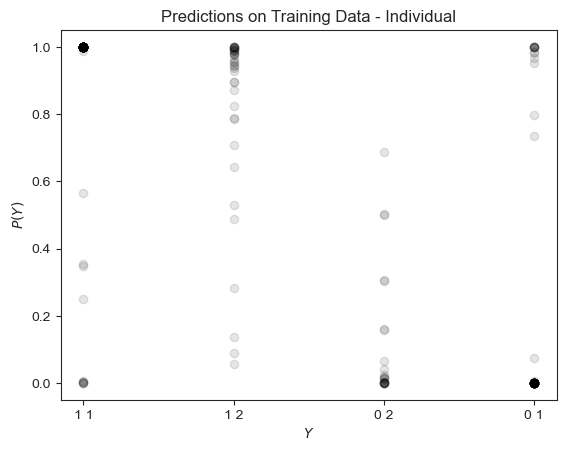

Training accuracy:
         P(Y)  accuracy  samples
Y                               
0   15.309960        66       82
1  106.999971       108      122


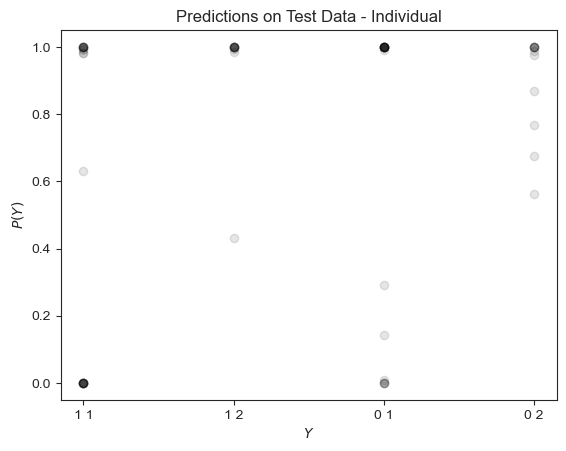

Test accuracy:
        P(Y)  accuracy  samples
Y                              
0  27.269516         7       35
1  23.987167        24       37


In [127]:
def visualize_results_regions(data, test_X, test_Y, test_regions, suffix='_indv', plot_suffix=''):
    t_out = pd.read_csv(f"/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output{suffix}.csv",
                        comment='#')
    print(t_out.head())
    t_betas = [[t_out[col][0] for col in t_out.columns if 'beta.1' in col],
               [t_out[col][0] for col in t_out.columns if 'beta.2' in col],
               [t_out[col][0] for col in t_out.columns if 'beta.3' in col]]

    scaled = []
    for i in range(len(data['X'])):
        scaled.append(np.array(t_betas[data['region'][i]-1]) * data['X'][i][:])

    # z = [t_out['alpha'][0] + sum(s) for s in scaled]
    z = [sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    print(len(data['Y']))
    print(len(Y_tilde))
    x_ax = []
    for i in range(len(data['Y'])):
        x_ax.append(str(data['Y'][i]) + ' ' + str(data['region'][i]))
    plt.scatter(x_ax, Y_tilde, color='k', alpha=0.1, zorder=-10)
    plt.ylabel(r'$P(Y)$')
    plt.xlabel(r'$Y$')
    plt.title(f"Predictions on Training Data{plot_suffix}")
    plt.show()
    print("Training accuracy:")
    accuracy = []
    for i in range(len(Y_tilde)):
        if Y_tilde[i] > 0.5:
            accuracy.append(1 if data['Y'][i] == 1 else 0)
        else:
            accuracy.append(1 if data['Y'][i] == 0 else 0)
    summary_table = pd.DataFrame({'Y': data['Y'], 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
    s_g = summary_table.groupby('Y').sum()
    print(s_g)


    scaled = []
    for i in range(len(test_X)):
        scaled.append(np.array(t_betas[test_regions[i]-1]) * test_X[i][:])
    # z = [t_out['alpha'][0] + sum(s) for s in scaled]
    z = [sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    x_ax = []
    for i in range(len(test_Y)):
        x_ax.append(str(test_Y[i]) + ' ' + str(test_regions[i]))
    plt.scatter(x_ax, Y_tilde, color='k', alpha=0.1, zorder=-10)
    plt.ylabel(r'$P(Y)$')
    plt.xlabel(r'$Y$')
    # plt.yscale('log')
    plt.title(f"Predictions on Test Data{plot_suffix}")
    plt.show()

    print("Test accuracy:")
    accuracy = []
    for i in range(len(Y_tilde)):
        if Y_tilde[i] > 0.5:
            accuracy.append(1 if test_Y[i] == 1 else 0)
        else:
            accuracy.append(1 if test_Y[i] == 0 else 0)
    summary_table = pd.DataFrame({'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
    s_g = summary_table.groupby('Y').sum()
    print(s_g)

visualize_results_regions(data_indv, test_X_indv, test_Y_indv, test_region_indv, suffix='_indv_region', plot_suffix=' - Individual')

In [ ]:
model = stan.build(model_laplace_region, data=data_indv)

In [ ]:
fit = model.sample(num_chains=4, num_samples=1000)

In [ ]:
fit_az = arviz.from_pystan(fit)
arviz.summary(fit_az)

In [ ]:
s_X = X[0]
s_X.sort()
print(max(s_X))
sns.histplot(s_X)

In [ ]:
# p_betas = [np.mean(x) for x in fit['beta']]
# sns.histplot(p_betas, label='sampled')
# sns.histplot(t_betas, label='optimized')
# plt.show()

plt.bar(np.abs(t_betas), label='optimized', bins=100)

In [ ]:
az.plot_trace(fit_simple_az, var_names=['alpha', 'beta', 'sigma']);
plt.tight_layout()

In [ ]:
# any diverging transitions?
print("Number of diverging samples: {}".format(fit['divergent__'].sum()))

In [ ]:
print(len(fit['beta']))

In [ ]:
# posterior of z
plt.figure(figsize=(4, 4))
sns.kdeplot(fit['beta'][:])
plt.xlabel(r"$\beta$")
plt.ylabel("Posterior density")
sns.despine()
plt.legend()

In [ ]:
# viz_scatter()
from sklearn.metrics import confusion_matrix
import random

correct_guesses = 0
total_guesses = 0
# add simulated data points
for i in range(10):
    idx = np.random.randint(0, 4000)
    scaled = [fit['beta'][:, idx] * x[:] for x in X]
    z = [fit['alpha'][0, idx] + sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
#     r = [random.random() for _ in range(len(Y_tilde))]
#     correct_guesses += len(r[r < Y_tilde])
#     total_guesses += len(r)

# print(correct_guesses / total_guesses)

plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# sns.despine()

In [ ]:
correct_guesses = 0
total_guesses = 0
# add simulated data points

scaled = [np.array(t_betas) * x[:] for x in X]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

plt.show()

In [ ]:
correct_guesses = 0
total_guesses = 0
# add simulated data points
sns.scatterplot(x=[i for i in range(len(t_betas))], y=t_betas)
plt.show()

scaled = [np.array(t_betas) * x[:] for x in test_X]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Test Data')
plt.show()

z.sort()
plt.scatter(z, np.exp(z) / (1 + np.exp(z)))
plt.xlabel('z')
plt.ylabel(r'$\tilde{Y}$')

accuracy = []
for i in range(len(Y_tilde)):
    if Y_tilde[i] > 0.5:
        accuracy.append(1 if test_Y[i] == 1 else 0)
    else:
        accuracy.append(1 if test_Y[i] == 0 else 0)
summary_table = pd.DataFrame({'ROI': test_column_list, 'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
print(summary_table)
s_g = summary_table.groupby('Y').sum()
print(s_g)

In [ ]:
X_to_use = np.array(X)
X_to_use = [x[abs_betas > 0.01] for x in X_to_use]
test_X_to_use = np.array(test_X)
test_X_to_use = [x[abs_betas > 0.01] for x in test_X_to_use]
scaled = [np.array(t_betas_to_use) * x[:] for x in X_to_use]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()

From https://www.cs.bham.ac.uk/~axk/laplace.pdf,
$$_t=\frac{\sum_n(y_n-\sum_{t'\neq t}w_{t'}x_{t'n})x_{tn}}{\sum_n x^2_{tn}}$$


### Evaluating the Laplace mixture model

In [ ]:
t_out = pd.read_csv("/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output.csv",
                    comment='#')
print(t_out.head())
t_alpha_beta = t_out['alpha_beta'][0]
t_alpha_gamma = t_out['alpha_gamma'][0]
pi = t_out['pi'][0]
print(pi)
t_betas = [t_out[col][0] for col in t_out.columns if 'beta.' in col]
t_gammas = [t_out[col][0] for col in t_out.columns if 'gamma.' in col]
print(sum(t_betas))
print(sum(t_gammas))
abs_betas = np.abs(t_betas)
np_betas = np.array(t_betas)
# genes_to_use = df[abs_betas > 0.01]['gene']
# t_betas_to_use = np_betas[abs_betas > 0.01]

In [ ]:
### Laplace Mix Model - training data

scaled = [pi * np.array(t_betas) * x[:] + (1-pi) * np.array(t_gammas) * x[:] for x in X]
z = [t_out['alpha_beta'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

plt.show()

In [ ]:
scaled = [pi * np.array(t_betas) * x[:] + (1-pi) * np.array(t_gammas) * x[:] for x in test_X]
z = [t_out['alpha_beta'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()

sns.scatterplot(x=[i for i in range(len(t_betas))], y=t_betas, c='b', s=2, label='beta')
sns.scatterplot(x=[i for i in range(len(t_gammas))], y=t_gammas, c='r', s=2, label='gamma')
plt.show()

accuracy = []
for i in range(len(Y_tilde)):
    if Y_tilde[i] > 0.5:
        accuracy.append(1 if test_Y[i] == 1 else 0)
    else:
        accuracy.append(1 if test_Y[i] == 0 else 0)
summary_table = pd.DataFrame({'ROI': test_column_list, 'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
print(summary_table)
s_g = summary_table.groupby('Y').sum()
print(s_g)